### Convolutional neural network

pp. 74 ~

Codes are imported from the previous practice.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 1. READ THE DATA: Download the dataset "CIFAR-10"

train_dataset = torchvision.datasets.CIFAR10(root='../CIFAR10', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../CIFAR10', train=False, transform=transforms.ToTensor(), download=True)

image, label = train_dataset[0]
print(image.size())
print(label)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [3]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [4]:
# (Optional) Check the size of the loaded dataset 

for images, labels in train_loader:
    print(images.size()) # loaded tensors
    print(images[0].size()) # first batch
    print(labels.size())
    break

torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([64])


In [5]:
num_classes = 10

In [6]:
# 2. DEFINE THE NETWORK: by mimicking AlexNet

class AlexNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet().to(device)

In [8]:
# 3 & 4. DEFINE LOSS FUNCTION AND OPTIMIZATION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [11]:
# 5. TRAIN THE NETWORK

num_epochs = 20

train_loss_list = [] # make an empty list for later use
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0 # set initial values for all the epoch
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    ##### train #####
    net.train()  # transform into training mode 
    # read by mini batch
    for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.view(-1, 32*32*3).to(device), labels.to(device) # transform into 1D and transfer to GPU
        images, labels = images.to(device), labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
        optimizer.zero_grad() # initialize the gradient
        outputs = net(images) # feedforward calculation
        loss = criterion(outputs, labels)
        train_loss +=loss.item()
        train_acc += (outputs.max(1)[1]==labels).sum().item()
        loss.backward() # backpropagation calculation
        optimizer.step() 

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    ##### evaluation #####
    net.eval() # switch to evaluation mode
    with torch.no_grad(): # gradient calculation is not required for the evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
            
        print("Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format
                  (epoch+1, num_epochs, i+1, loss = avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
            
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)


Epoch [1/20], Loss: 0.0240, val_loss: 0.0221, val_acc: 0.4886
Epoch [2/20], Loss: 0.0215, val_loss: 0.0230, val_acc: 0.4618
Epoch [3/20], Loss: 0.0199, val_loss: 0.0205, val_acc: 0.5337
Epoch [4/20], Loss: 0.0185, val_loss: 0.0189, val_acc: 0.5700
Epoch [5/20], Loss: 0.0170, val_loss: 0.0189, val_acc: 0.5731
Epoch [6/20], Loss: 0.0157, val_loss: 0.0173, val_acc: 0.6088
Epoch [7/20], Loss: 0.0145, val_loss: 0.0169, val_acc: 0.6237
Epoch [8/20], Loss: 0.0134, val_loss: 0.0178, val_acc: 0.6080
Epoch [9/20], Loss: 0.0123, val_loss: 0.0170, val_acc: 0.6307
Epoch [10/20], Loss: 0.0113, val_loss: 0.0175, val_acc: 0.6269
Epoch [11/20], Loss: 0.0103, val_loss: 0.0185, val_acc: 0.6159
Epoch [12/20], Loss: 0.0094, val_loss: 0.0183, val_acc: 0.6243
Epoch [13/20], Loss: 0.0086, val_loss: 0.0182, val_acc: 0.6413
Epoch [14/20], Loss: 0.0077, val_loss: 0.0194, val_acc: 0.6192
Epoch [15/20], Loss: 0.0070, val_loss: 0.0187, val_acc: 0.6416
Epoch [16/20], Loss: 0.0064, val_loss: 0.0204, val_acc: 0.6346
E

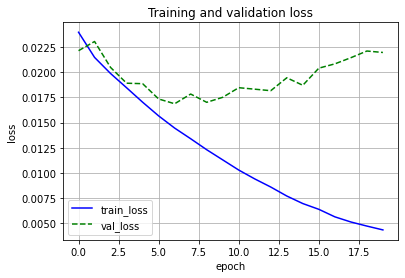

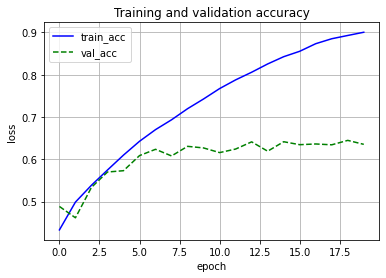

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'green', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'green', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation accuracy')
plt.grid()

In [ ]:
# Note that the Convolutional network outperforms the MLP network